# 参数化值迭代

In [6]:
#-*-coding:utf-8-*-
from GameEnv import Game2048
from DQN import DQN
import random
import copy

def check_one_game(gameEnv,debug):
    gameEnv.reset()
    flag = False
    observation = copy.deepcopy(gameEnv.matrix)
    while True:
        if debug:gameEnv.display()

        action = random.choice(["a","w","d","s"])
        observation_, reward, done = gameEnv.step(action)
        flag = True if observation_ == observation else False
        observation = copy.deepcopy(observation_)
        if debug:print("_________________________________________")
        if done:
            if debug:gameEnv.display()
            if debug:print("this_score_____________________:",gameEnv.score)
            break
    return gameEnv.score

def evaluate(gameEnv):
    scores = []
    n = 1000
    for i in range(n):
        scores.append(check_one_game(gameEnv,False))
    print "avg:%d max:%d min:%d "%(np.average(scores),np.max(scores), np.min(scores))
    
gameEnv = Game2048()
gameEnv.grid_n = 3

In [7]:
evaluate(gameEnv)

avg:165 max:744 min:12 


In [8]:
# 策略评估
import itertools
import numpy as np
def move(mtr, dirct):
    grid_n = 2
    score = 0
    visit = []
    if dirct == 0:  # left
        for i in range(grid_n):
            for j in range(1, grid_n):
                for k in range(j, 0, -1):
                    if mtr[i][k - 1] == 0:
                        mtr[i][k - 1] = mtr[i][k]
                        mtr[i][k] = 0
                    elif mtr[i][k - 1] == mtr[i][k] and grid_n * i + k - 1 not in visit and grid_n * i + k not in visit:
                        mtr[i][k - 1] *= 2
                        mtr[i][k] = 0
                        score += mtr[i][k - 1]
                        visit.append(grid_n * i + k)
                        visit.append(grid_n * i + k - 1)
                        # for i in range(4):
                        #    for j in range(3):

    elif dirct == 1:  # down
        for j in range(grid_n):
            for i in range(grid_n-1, 0, -1):
                for k in range(0, i):
                    if mtr[k + 1][j] == 0:
                        mtr[k + 1][j] = mtr[k][j]
                        mtr[k][j] = 0
                    elif mtr[k + 1][j] == mtr[k][j] and (grid_n * (k + 1) + j) not in visit and (grid_n * k + j) not in visit:
                        mtr[k + 1][j] *= 2
                        mtr[k][j] = 0
                        score += mtr[k + 1][j]
                        visit.append(grid_n * (k) + j)
                        visit.append(grid_n * (k + 1) + j)


    elif dirct == 2:  # up
        for j in range(grid_n):
            for i in range(1, grid_n):
                for k in range(i, 0, -1):
                    if mtr[k - 1][j] == 0:
                        mtr[k - 1][j] = mtr[k][j]
                        mtr[k][j] = 0
                    elif mtr[k - 1][j] == mtr[k][j] and (grid_n * (k - 1) + j) not in visit and (grid_n * k + j) not in visit:
                        mtr[k - 1][j] *= 2
                        mtr[k][j] = 0
                        score += mtr[k - 1][j]
                        visit.append(grid_n * (k) + j)
                        visit.append(grid_n * (k - 1) + j)

    elif dirct == 3:  # right
        for i in range(grid_n):
            for j in range(grid_n-1, 0, -1):
                for k in range(j):
                    if mtr[i][k + 1] == 0:
                        mtr[i][k + 1] = mtr[i][k]
                        mtr[i][k] = 0
                    elif mtr[i][k] == mtr[i][k + 1] and grid_n * i + k + 1 not in visit and grid_n * i + k not in visit:
                        mtr[i][k + 1] *= 2
                        mtr[i][k] = 0
                        score += mtr[i][k + 1]
                        visit.append(grid_n * i + k + 1)
                        visit.append(grid_n * i + k)

    return score

def test_step(matrix,action):
    if action == "a":
            dirct = 0
    elif action == "s":
        dirct = 1
    elif action == "w":
        dirct = 2
    elif action == "d":
        dirct = 3
            
    tmp = copy.deepcopy(matrix)
    score = move(matrix,dirct)
    res_list = []
    if tmp == matrix:
        return [tmp],0
    for i in range(2):
        for j in range(2):
            if matrix[i][j] == 0:
                copy_matrix_2 = copy.deepcopy(matrix)
                copy_matrix_4 = copy.deepcopy(matrix)
                copy_matrix_2[i][j] = 2
                copy_matrix_4[i][j] = 4
                res_list.append(copy_matrix_2)
                res_list.append(copy_matrix_4)
    return res_list,score

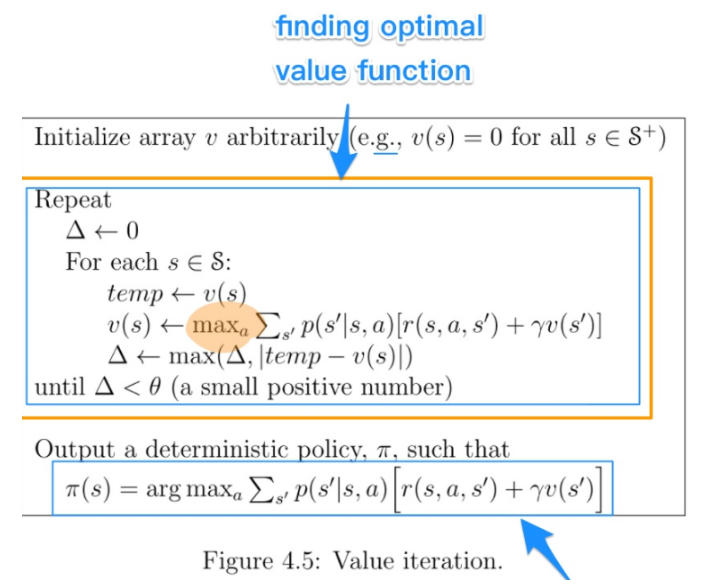

In [9]:
def transform(stauts):
    return np.array(eval(status)).reshape(2,2).tolist()

def transform_key(status):
    return str(tuple(np.array(status).reshape(-1)))

def e_greedy(action,e):
    if random.random() < e:
        return random.choice(["a","s","w","d"])
    else:
        return action 
    
def value_iteration():
    hold = 0.000001
    # 初始化所有状态
    dqn = DQN()
    s_list = []
    for s in list(itertools.permutations([0,0,0,2,2,2,4,4,4,8,8,8,16,16,16,32],4)):
        s_list.append(str(s))
    
    while True:
        delta = 0
        for s in s_list:
            temp = dqn.get_value([s])
            # find max_a v
            max_score = 0
            max_action = ["a"]
            for action in ["a","s","w","d"]:                
                observation_next_list, reward = test_step(transform(s),action)
                statis_dict = {}
                for i in range(len(observation_next_list)):
                    if transform_key(observation_next_list[i]) in statis_dict:
                        if action in statis_dict:
                            statis_dict[action].append(res[transform_key(observation_next_list[i])])
                        else:
                            statis_dict[action] = [res[transform_key(observation_next_list[i])]]
                for i in statis_dict:
                    if len(statis_dict[i]) > 1:
                        if np.average(statis_dict[i]) > max_score:
                            max_score = np.average(statis_dict[i])
                            max_action = [i]
            vs = max_score
            v_dict[s] = vs
            delta = max(delta,abs(temp - vs))
        if delta < hold:
            break
    return v_dict

def get_policy(res):
     # 策略迭代
    policy = {}
    for s in res:
        max_score = -2
        max_action = ["a"]
        for action in ["a","s","w","d"]:                
            observation_next_list, reward = test_step(transform(s),action)
            statis_dict = {}
            for i in range(len(observation_next_list)):
                if str(tuple(np.array(observation_next_list[i]).reshape(-1))) in res:
                    if action in statis_dict:
                        statis_dict[action].append(res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])
                    else:
                        statis_dict[action] = [res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))]]
            for i in statis_dict:
                if len(statis_dict[i]) > 1:
                    if np.average(statis_dict[i]) > max_score:
                        max_score = np.average(statis_dict[i])
                        max_action = [i]
            policy[s] = max_action
    return policy